In [1]:
import cv2
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing import image

Using TensorFlow backend.


In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

In [3]:
base_dir = './style_train_base/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [4]:
def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,3))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [5]:
train_sampel = 848

train_features, train_labels = extract_features(train_dir, train_sampel) #5096

Found 848 images belonging to 3 classes.


In [6]:
validation_sample = 424

validation_features, validation_labels = extract_features(validation_dir, validation_sample) # 2548

Found 424 images belonging to 3 classes.


In [7]:
test_sample = 426

test_features, test_labels = extract_features(test_dir, test_sample) #2547

Found 426 images belonging to 3 classes.


In [8]:
train_features = np.reshape(train_features,(train_sampel, 4 * 4 * 512))
validation_features = np.reshape(validation_features,(validation_sample, 4 * 4 * 512))
test_features = np.reshape(test_features,(test_sample, 4 * 4 * 512))

In [9]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_pattern_0424.h5', monitor='val_loss', mode='min', save_best_only=True)

In [10]:
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
                         loss='categorical_crossentropy',
                         metrics=['acc'])

In [11]:
history = model.fit(train_features, train_labels,
                   epochs=500,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels),
                   callbacks=[es,mc])

Train on 848 samples, validate on 424 samples
Epoch 1/500
848/848 [==============================] - 1s 1ms/step - loss: 1.2471 - acc: 0.3903 - val_loss: 1.0692 - val_acc: 0.3892
Epoch 2/500
848/848 [==============================] - 1s 1ms/step - loss: 1.0732 - acc: 0.4505 - val_loss: 1.0210 - val_acc: 0.4764
Epoch 3/500
848/848 [==============================] - 1s 1ms/step - loss: 1.0136 - acc: 0.4917 - val_loss: 0.9850 - val_acc: 0.4811
Epoch 4/500
848/848 [==============================] - 1s 1ms/step - loss: 0.8917 - acc: 0.5731 - val_loss: 0.9469 - val_acc: 0.5212
Epoch 5/500
848/848 [==============================] - 1s 1ms/step - loss: 0.8105 - acc: 0.6368 - val_loss: 0.9292 - val_acc: 0.5259
Epoch 6/500
848/848 [==============================] - 1s 1ms/step - loss: 0.8089 - acc: 0.6297 - val_loss: 0.9172 - val_acc: 0.5542
Epoch 7/500
848/848 [==============================] - 1s 1ms/step - loss: 0.7344 - acc: 0.6899 - val_loss: 0.9139 - val_acc: 0.5094
Epoch 8/500
848/848 [==

848/848 [==============================] - 1s 1ms/step - loss: 0.0889 - acc: 0.9882 - val_loss: 0.9492 - val_acc: 0.5802
Epoch 62/500
848/848 [==============================] - 1s 1ms/step - loss: 0.0949 - acc: 0.9882 - val_loss: 1.0105 - val_acc: 0.5849
Epoch 63/500
848/848 [==============================] - 1s 1ms/step - loss: 0.0941 - acc: 0.9906 - val_loss: 0.9689 - val_acc: 0.5778
Epoch 64/500
848/848 [==============================] - 1s 1ms/step - loss: 0.0839 - acc: 0.9976 - val_loss: 0.9637 - val_acc: 0.5896
Epoch 65/500
848/848 [==============================] - 1s 1ms/step - loss: 0.0781 - acc: 0.9953 - val_loss: 0.9740 - val_acc: 0.5873
Epoch 66/500
848/848 [==============================] - 1s 1ms/step - loss: 0.0734 - acc: 0.9941 - val_loss: 0.9760 - val_acc: 0.5825
Epoch 67/500
848/848 [==============================] - 1s 1ms/step - loss: 0.0748 - acc: 0.9953 - val_loss: 1.0129 - val_acc: 0.5755
Epoch 68/500
848/848 [==============================] - 1s 1ms/step - loss:

In [12]:
model.save('style_0427.h5')

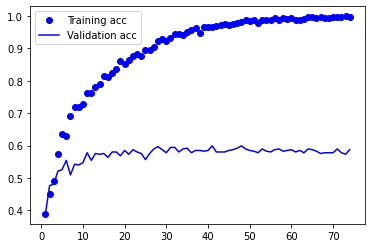

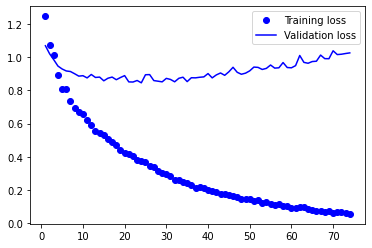

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
# plt.tilte('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
# plt.tilte('Training and validation loss')
plt.legend()

plt.show()

In [14]:
model.save_weights('style_weights_0427.h5')